# Projeto Final

Somos uma empresa de telecomunicações, estamos com uma taxa de _churn_ indesejável. Com base nos dados informados temos que criar um modelo para nos informar queias o clientes mais propensos ao _churn_.<br>
<br>
Para isso dividiremos o problema em 3 partes:<br>
1. Entendimento dos dados:
    - Planejar como o problema será abordado
    - Limpar os dados
    - EDA
2. Modelagem:
    - Definição de métricas de avaliação
    - Feature Engineering
    - Contrução pipeline treinamento / avaliação dos modelos
    - Tuning & Model Selection
3. Relatporio Final:
    - Análise do modelo de forma extensiva. Quais seus pontos fortes e fracos
    - Responder às seguintes perguntas:<br>
        1) Quais os passos do plano foram executados e quais foram pulados (explique o por quê)?<br>
        2) Quais as dificuldades você encontrou e como conseguiu resolvê-las?<br>
        3) Quais foram algumas das etapas principais na resolução da tarefa?<br>
        4) Qual é o seu modelo final e qual pontuação de qualidade ele tem?<br>


## 1. Inicialização do Dados

In [4]:
#Bicliotecas para carregar e visualizar os dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import set_config

# Bibliotecas para preprocessamento dos dados
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Bibliotecas para tunagem dos modelos
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Bibliotecas de Modelos utilizados
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# Bibliotecas para avaliar os modelos
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
path = '/datasets/'
contract = pd.read_csv(path+'contract.csv')
internet = pd.read_csv(path+'internet.csv')
personal = pd.read_csv(path+'personal.csv')
phone = pd.read_csv(path+'phone.csv')

## 2. Compreensão dos dados

In [7]:
def df_basic_info(df):
    print('Informações do DataFrame:')
    print(df.info())
    print("--------------------------------------------------------------------------------------------")
    print('Primeiros valores do DataFrame:')
    print(df.head())
    print("--------------------------------------------------------------------------------------------")
    print('Duplicatas explícitas:', df.duplicated().sum())
    print("--------------------------------------------------------------------------------------------")
    print('Valores Nulos:')
    if (df.isna().sum().sum() == 0):
        print('Não há valores nulos')
    else:
        print(f'Existem {nulos} valores nulos')
    
    

In [8]:
df_basic_info(contract)

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
--------------------------------------------------------------------------------------------
Primeiros valores do DataFrame:
   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2

- Ao verificar os tipos de dados das colunas do Dataframe podemos fazer as seguintes alterações:
    - BeginDate para datetime
    - EndDate para datetime
    - PaperlessBilling para boolean
    - TotalCharges para float<br>
A Alteração nas datas nos permitirá fazer cálculos relacionados a data, especialmente quanto tempo de duração tem o contrato, porém isso será feito na etapa de enriquecimento de dados. <br>
A Coluna PaperlessBilling será alterada para boolean para ser melhor processada.<br>
A Coluna TotalCharges será tranformada em float pois é composta de valores numéricos


In [9]:
# Tranformando as colunas de datas
contract["BeginDate"] = pd.to_datetime(contract["BeginDate"])
contract["EndDate"] = pd.to_datetime(contract["EndDate"], errors='coerce')

In [10]:
# Convertendo PaperlessBilling
d = {"No": 0, "Yes": 1}
contract["PaperlessBilling"] = contract["PaperlessBilling"].map(d)

In [11]:
# Converter a Coluna TotalCharges com o código abaixo da erro devido a valores '', ou seja, nulos :
# data['TotalCharges'] = data['TotalCharges'].astype(float)

# Dividindo os valores da coluna para identificar quais valores estão nulos
l1 = [len(i.split()) for i in contract['TotalCharges']]
l2 = [i for i in range(len(l1)) if l1[i] != 1]
print('Index Positions with empty spaces : ',*l2)

Index Positions with empty spaces :  488 753 936 1082 1340 3331 3826 4380 5218 6670 6754


In [12]:
# Ao verificar os contratos novos, percebemos que são os mesmo que possuem 'TotalCharges' nulos 
# porque ainda não houve cobrança
contract[(contract['BeginDate'].dt.month == 2) & (contract['BeginDate'].dt.year == 2020)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,NaT,Two year,1,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,NaT,Two year,0,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,NaT,Two year,0,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,NaT,Two year,0,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,NaT,Two year,0,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,NaT,Two year,0,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,NaT,Two year,0,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,NaT,Two year,0,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,NaT,One year,1,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,NaT,Two year,0,Mailed check,73.35,


In [13]:
# Portanto atribuiremos o valor zero para esses registros e usar a linha para conversão

for i in l2:
    contract.loc[i,'TotalCharges'] = '0'
    
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

In [14]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 440.3+ KB


In [15]:
df_basic_info(internet)

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
--------------------------------------------------------------------------------------------
Primeiros valores do DataFrame:
   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2 

Transformar os dados que são 'Yes' ou 'Não' como booleanos para melhor desempenho no treinamento do modelo

In [16]:
for c in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    internet[c] = internet[c].map(d)

In [17]:
df_basic_info(personal)

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
--------------------------------------------------------------------------------------------
Primeiros valores do DataFrame:
   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No
-------------------------------------------------

Transformar os dados que são 'Yes' ou 'Não' como booleanos para melhor desempenho no treinamento do modelo

In [18]:
personal["Partner"] = personal["Partner"].map(d)
personal["Dependents"] = personal["Dependents"].map(d)

In [19]:
personal['SeniorCitizen'].unique()

array([0, 1], dtype=int64)

In [20]:
df_basic_info(phone)

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
--------------------------------------------------------------------------------------------
Primeiros valores do DataFrame:
   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes
--------------------------------------------------------------------------------------------
Duplicatas explícitas: 0
--------------------------------------------------------------------------------------------
Valores Nulos:
Não há valores nulos


In [21]:
phone["MultipleLines"] = phone["MultipleLines"].map(d)

## 3. Enriquecimento dos Dados

Ainda precisamos determinar o nosso alvo, os clientes que deixaram a empresa.

In [22]:
# Os clientes que deixaram a empresa são aquelas que possuem algum valor em "EndDate" no DataFrame contract
# Sendo 0 os clientes que tem contrato com a empresa e 1 os que deixaram
contract['Churn'] = contract['EndDate'].apply(lambda x: 0 if pd.isna(x) else 1)
contract['Churn'].mean()

0.2653698707936959

Com isso temos uma taxa de Churn de 26,5%

Para calcular o tempo de contrato de cada registro será utilizada a seguinte metodologia:<br> 
- Para os registros que não possuem EndDate, ou seja, vigentes, a data referência será Fevereiro de 2020<br>
- Para os que possuem EndDate válido o valor será subtraido do BeginDate e será usado a quantidade de meses como métrica

In [23]:
contract['Tenure'] = contract['TotalCharges'] / contract['MonthlyCharges']

In [24]:
def diff_calc(df):
    m1 = df['BeginDate'].month
    y1 = df['BeginDate'].year
    if not(pd.isna(df['EndDate'])):
        m2 = df['EndDate'].month
        y2 = df['EndDate'].year
    else:
        m2 = 2
        y2 = 2020
    diff = (y2 - y1)*12 + m2 - m1
    return diff

In [25]:
contract['Tenure'] = contract.apply(diff_calc, axis=1)
contract[['BeginDate', 'EndDate', 'Tenure']]

,BeginDate,EndDate,Tenure
0,2020-01-01,NaT,1
1,2017-04-01,NaT,34
2,2019-10-01,2019-12-01,2
3,2016-05-01,NaT,45
4,2019-09-01,2019-11-01,2
...,...,...,...
7038,2018-02-01,NaT,24
7039,2014-02-01,NaT,72
7040,2019-03-01,NaT,11
7041,2019-07-01,2019-11-01,4


In [26]:
contract[contract['Tenure']==0][['BeginDate', 'EndDate', 'Tenure']]

,BeginDate,EndDate,Tenure
488,2020-02-01,NaT,0
753,2020-02-01,NaT,0
936,2020-02-01,NaT,0
1082,2020-02-01,NaT,0
1340,2020-02-01,NaT,0
3331,2020-02-01,NaT,0
3826,2020-02-01,NaT,0
4380,2020-02-01,NaT,0
5218,2020-02-01,NaT,0
6670,2020-02-01,NaT,0


Os dados estão em locais diferentes, todos os dados serão juntados em um só dataframe para melhor correlação e também para alimentar as características dos modelos

In [27]:
from functools import reduce
dfs = [contract, internet, personal, phone]
df_final = reduce(lambda left, right: pd.merge(left, right, on='customerID', how='outer'), dfs)
df_final.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Tenure,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,0002-ORFBO,2019-05-01,NaT,One year,1,Mailed check,65.60,593.30,0,9,...,1.0,0.0,1.0,1.0,0.0,Female,0,1,1,0.0
1,0003-MKNFE,2019-05-01,NaT,Month-to-month,0,Mailed check,59.90,542.40,0,9,...,0.0,0.0,0.0,0.0,1.0,Male,0,0,0,1.0
2,0004-TLHLJ,2019-09-01,2020-01-01,Month-to-month,1,Electronic check,73.90,280.85,1,4,...,0.0,1.0,0.0,0.0,0.0,Male,0,0,0,0.0
3,0011-IGKFF,2018-12-01,2020-01-01,Month-to-month,1,Electronic check,98.00,1237.85,1,13,...,1.0,1.0,0.0,1.0,1.0,Male,1,1,0,0.0
4,0013-EXCHZ,2019-09-01,2019-12-01,Month-to-month,1,Mailed check,83.90,267.40,1,3,...,0.0,0.0,1.0,1.0,0.0,Female,1,1,0,0.0
5,0013-MHZWF,2019-05-01,NaT,Month-to-month,1,Credit card (automatic),69.40,571.45,0,9,...,0.0,0.0,1.0,1.0,1.0,Female,0,0,1,0.0
6,0013-SMEOE,2014-03-01,NaT,Two year,1,Bank transfer (automatic),109.70,7904.25,0,71,...,1.0,1.0,1.0,1.0,1.0,Female,1,1,0,0.0
7,0014-BMAQU,2014-11-01,NaT,Two year,1,Credit card (automatic),84.65,5377.80,0,63,...,0.0,0.0,1.0,0.0,0.0,Male,0,1,0,1.0
8,0015-UOCOJ,2019-07-01,NaT,Month-to-month,1,Electronic check,48.20,340.35,0,7,...,0.0,0.0,0.0,0.0,0.0,Female,1,0,0,0.0
9,0016-QLJIS,2014-09-01,NaT,Two year,1,Mailed check,90.45,5957.90,0,65,...,1.0,1.0,1.0,1.0,1.0,Female,0,1,1,1.0


Os dataframes Internet e Phone possuem menos registros que os dataframes contract e personal, portanto vamos tratar os valores nulos gerados. 

In [28]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   Tenure            7043 non-null   int64         
 10  InternetService   5517 non-null   object        
 11  OnlineSecurity    5517 non-null   float64       
 12  OnlineBackup      5517 non-null   float64       
 13  DeviceProtection  5517 non-null   float64       
 14  TechSupport       5517 n

In [29]:
numerics = ['int64', 'float64']
numeric_columns = df_final.select_dtypes(include=numerics).columns.values
df_final[numeric_columns] = df_final[numeric_columns].fillna(2)

In [30]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   Tenure            7043 non-null   int64         
 10  InternetService   5517 non-null   object        
 11  OnlineSecurity    7043 non-null   float64       
 12  OnlineBackup      7043 non-null   float64       
 13  DeviceProtection  7043 non-null   float64       
 14  TechSupport       7043 n

A única coluna que possui valores nulos, com exceção de EndDate mas para essa não teremos utilidade, é a Internet Service, que são aqueles cliente que não assinam serviço de internet, os dados serão tratados da seguinte forma: 0 - DSL, 1 - Fibra Óptica e 2 - Não possui Serviço de Internet

In [31]:
dic = {'DSL': 0, 'Fiber optic': 1}
df_final['InternetService'] = df_final['InternetService'].map(dic)
df_final['InternetService'].fillna(2, inplace=True)
df_final['InternetService'].unique()

array([0., 1., 2.])

Concluídos o trabalho dos dados, dividiremos entre os clientes que romperam contrato e os que não romperam para analisar as diferenças entre os grupos.<br>

Antes da divisão as colunas customerID, BeginDate e EndDate não reprentam informações para a análise portanto serão ignoradas na análise das características.

In [32]:
churned = df_final[df_final['Churn'] == 1].drop(['customerID', 'BeginDate', 'EndDate'], axis=1)
not_churned = df_final[df_final['Churn'] == 0].drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

In [33]:
churned.describe().T

,count,mean,std,min,25%,50%,75%,max
PaperlessBilling,1869.0,0.749064,0.433668,0.00,0.00,1.00,1.0,1.00
MonthlyCharges,1869.0,74.441332,24.666053,18.85,56.15,79.65,94.2,118.35
TotalCharges,1869.0,1531.796094,1890.822994,18.85,134.50,703.55,2331.3,8684.80
Churn,1869.0,1.000000,0.000000,1.00,1.00,1.00,1.0,1.00
Tenure,1869.0,17.979133,19.531123,1.00,2.00,10.00,29.0,72.00
InternetService,1869.0,0.814874,0.521459,0.00,1.00,1.00,1.0,2.00
OnlineSecurity,1869.0,0.278759,0.567578,0.00,0.00,0.00,0.0,2.00
OnlineBackup,1869.0,0.400749,0.601051,0.00,0.00,0.00,1.0,2.00
DeviceProtection,1869.0,0.412520,0.602878,0.00,0.00,0.00,1.0,2.00
TechSupport,1869.0,0.286784,0.570643,0.00,0.00,0.00,0.0,2.00


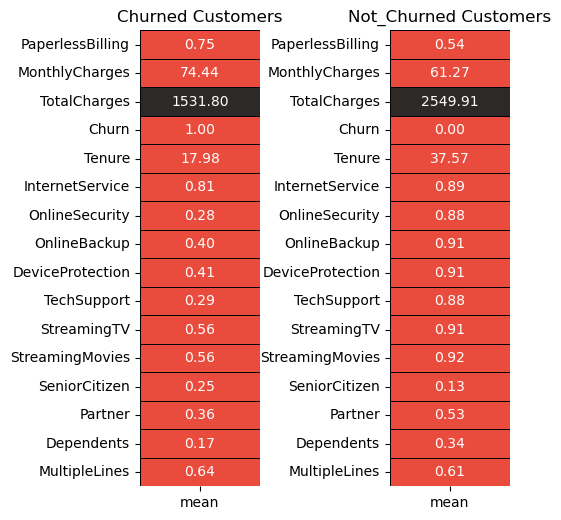

In [34]:
colors = ['#E94B3C','#2D2926']

#churn = df1[df1['Churn'] == 1].describe().T
#not_churn = df1[df1['Churn'] == 0].describe().T

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (5,5))
plt.subplot(1,2,1)
sns.heatmap(churned.describe().T[['mean']],annot = True,cmap = colors,
            linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('Churned Customers');

plt.subplot(1,2,2)
sns.heatmap(not_churned.describe().T[['mean']],annot = True,cmap = colors,
            linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f',)
plt.title('Not_Churned Customers');

fig.tight_layout(pad = 0)

As colunas que mais diferem em ambos conjuntos é o tempo de contrato, StreamingMovies, SeniorCitizen, OnlineBackup, TechSupport e StreamingTV, porém alguns serviços não são para todos os clientes, portanto o valor 2 para aqueles que não possuem serviço de internet ou telefone pode estar influenciando nessas colunas. <br>
A coluna de tempo de contrato 'Tenure' não tem essa característica e parece impactar no fator de Churn. Outras colunas que parecem ter influência na decisão é o preço mensal cobrado, que tem média maior para os clientes que não possuem mais contrato, e cobrança sem papel, os clientes que permanecem na empresa possuem menos cobrança em papel.

## 4. Análise tendência dos Dados

In [35]:
# Separando as colunas de acordo com os Dataframes de onde vieram para procurar padrões dentro deles
l_pers_cols = []
l_phone_cols = []
l_internet_cols = []

for c in churned.columns.values:
    if c in list(personal.columns.values):
        l_pers_cols.append(c)
    if c in list(phone.columns.values):
        l_phone_cols.append(c)
    if c in list(internet.columns.values):
        l_internet_cols.append(c)

### 4.1 Tempo de contrato

Primeiramente, qual a diferença entre a duração dos planos no clientes que deixaram a empresa e os que mantém contrato

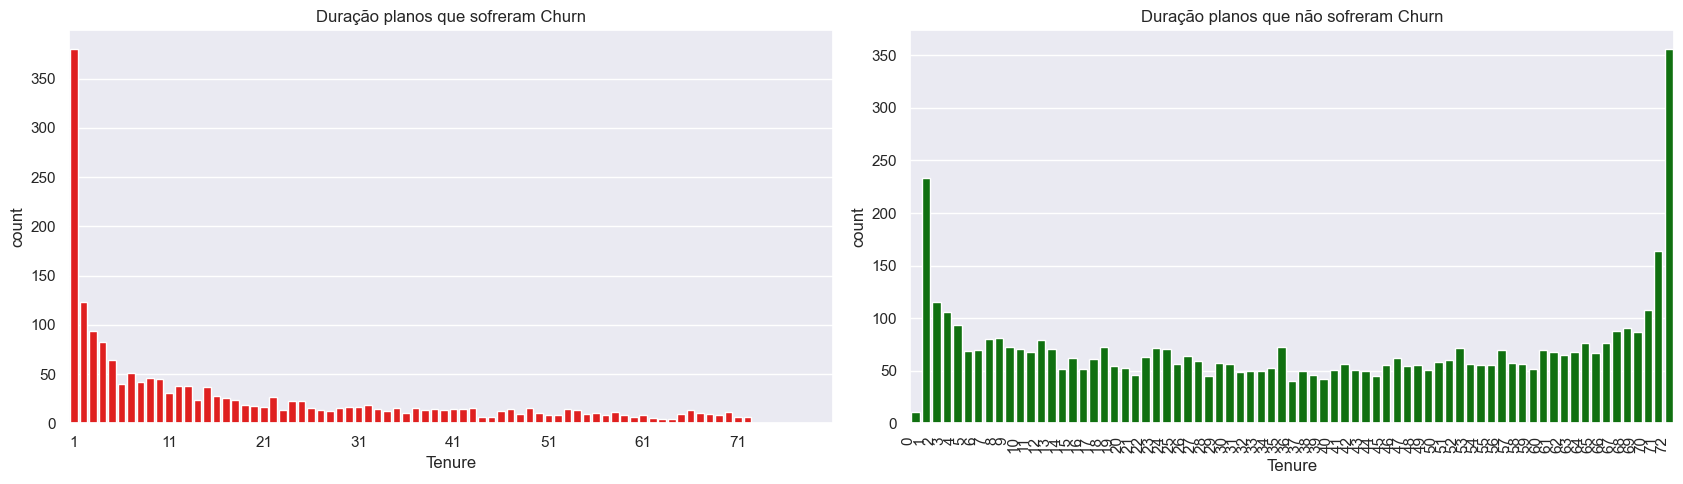

In [36]:
plt.figure(figsize=(17,5))
sns.set()
plt.subplot(1, 2, 1)
sns.countplot(data=churned, x="Tenure", color='red')

plt.title('Duração planos que sofreram Churn')
plt.xticks(np.arange(0, 90, 10))

plt.subplot(1, 2, 2)

sns.countplot(data=not_churned, x="Tenure", color='green')
plt.xticks(rotation=90, ha='right')

plt.title('Duração planos que não sofreram Churn')

plt.tight_layout()
plt.show()

Os clientes que saíram tem muita concentração em até 10 meses. Enquanto que os clientes tem distribuição maior entre a duração dos planos. Os clientes têm a tendência de encerrar o contrato em menos de um ano.

### 4.2 Informações pessoais Clientes

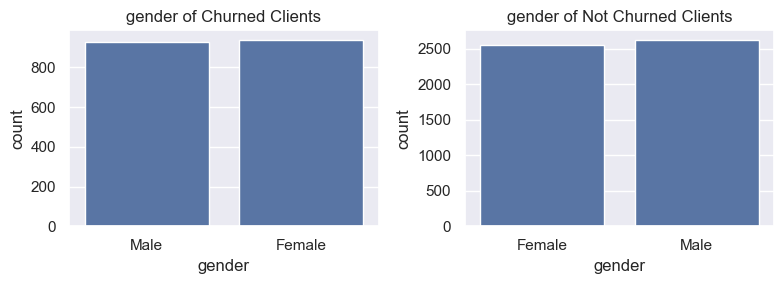

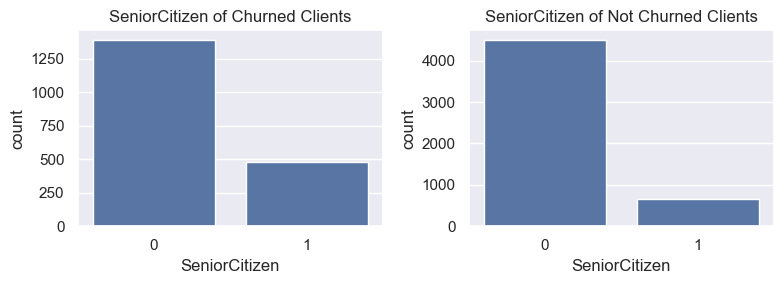

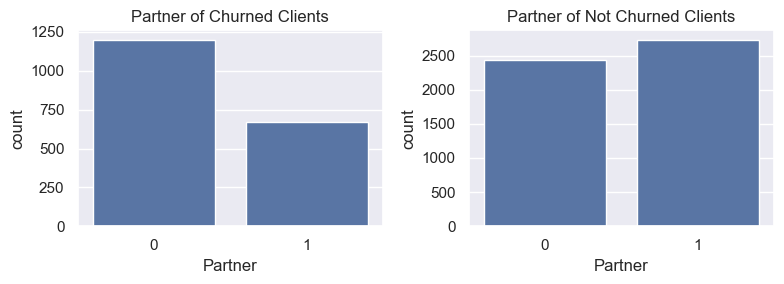

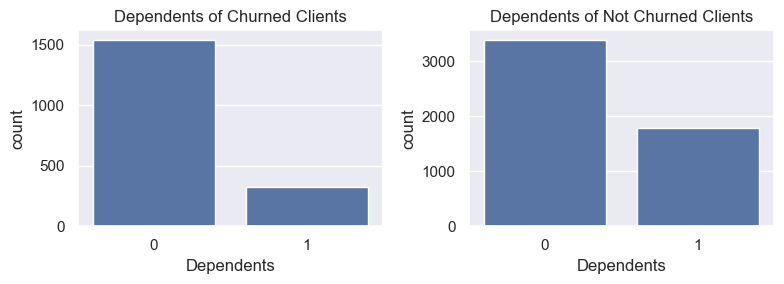

In [37]:
for i in l_pers_cols:
    plt.figure(figsize=(8,3))

    plt.subplot(1, 2, 1)
    #sns.countplot(data=churned, x="SeniorCitizen")
    sns.countplot(data=churned, x=i)
    plt.title(f'{i} of Churned Clients')
    #plt.title('Duração planos que sofreram Churn')

    plt.subplot(1, 2, 2)

    #sns.countplot(data=not_churned, x="SeniorCitizen")
    sns.countplot(data=not_churned, x=i)
    #plt.title('Duração planos que não sofreram Churn')
    plt.title(f'{i} of Not Churned Clients')
    
    plt.tight_layout()
    plt.show()

O gênero do cliente não influencia na decisão de terminar o contrato. <br>
Clientes com mais idade têm presença relativa maior nos Clientes que romperam contrato. Enquanto que usuários que possuem parceiros ou dependentes tem mais tendência de manter o plano.

### 4.3 Clientes com Múltiplas Linhas

Analisando o impacto de múltiplas linhas para o Churn de clientes

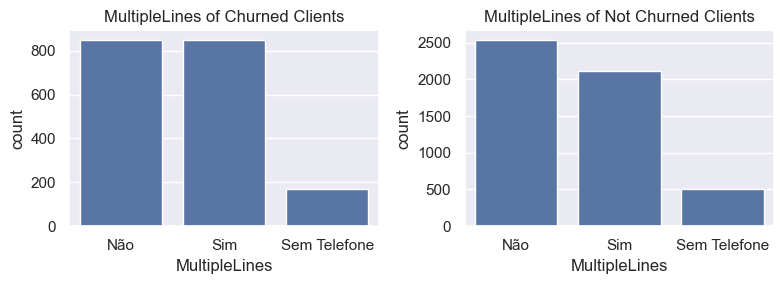

In [38]:
for i in l_phone_cols:
    plt.figure(figsize=(8,3))

    plt.subplot(1, 2, 1)
    sns.countplot(data=churned, x=i)
    plt.title(f'{i} of Churned Clients')
    plt.xticks(np.arange(3), ['Não', 'Sim', 'Sem Telefone'])

    plt.subplot(1, 2, 2)
    sns.countplot(data=not_churned, x=i)
    plt.title(f'{i} of Not Churned Clients')
    plt.xticks(np.arange(3), ['Não', 'Sim', 'Sem Telefone'])
    
    plt.tight_layout()
    plt.show()

A quantidade de linhas tem um impacto pequeno na decisão de romper o contrato. Sendo que um impacto pouco negativo pelos nossos dados.

### 4.4 Clientes com Serviços de Internet

Considerando pelo Serviço de Internet

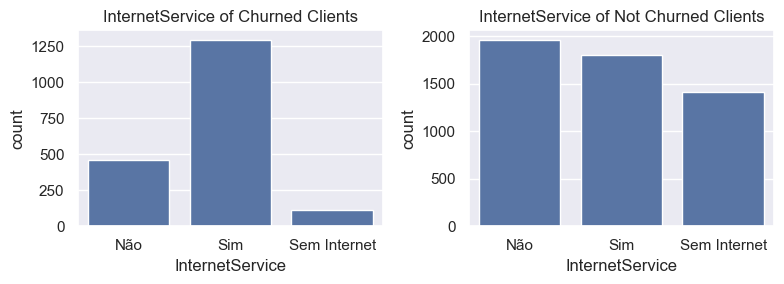

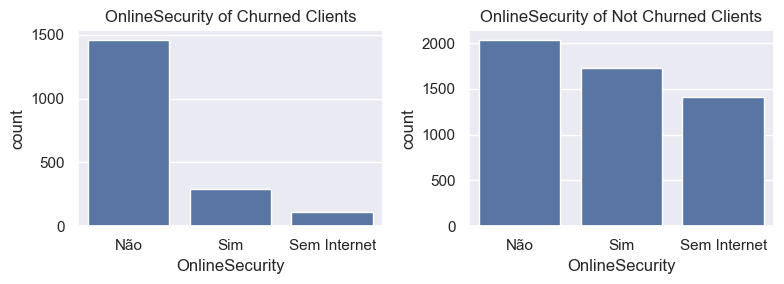

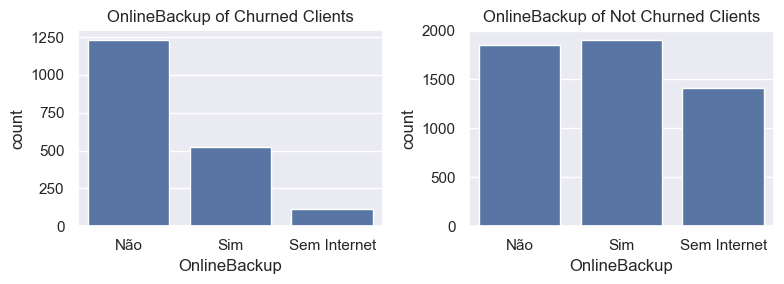

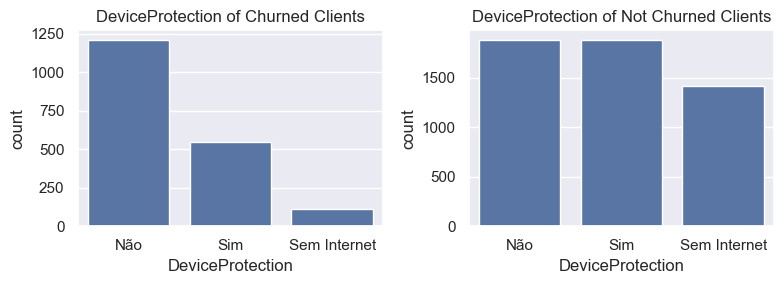

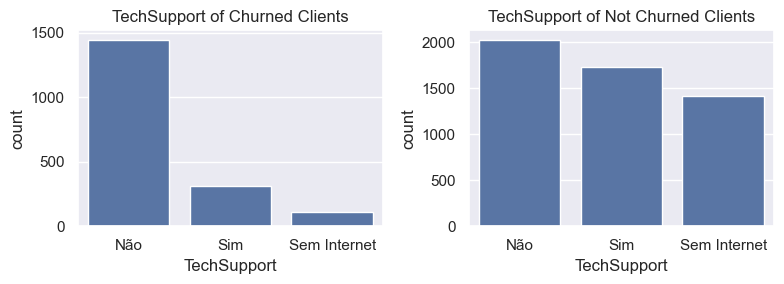

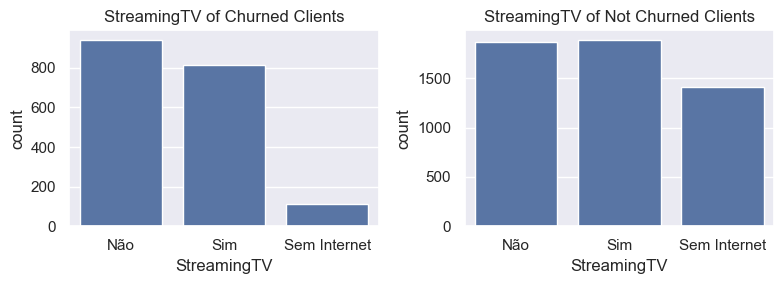

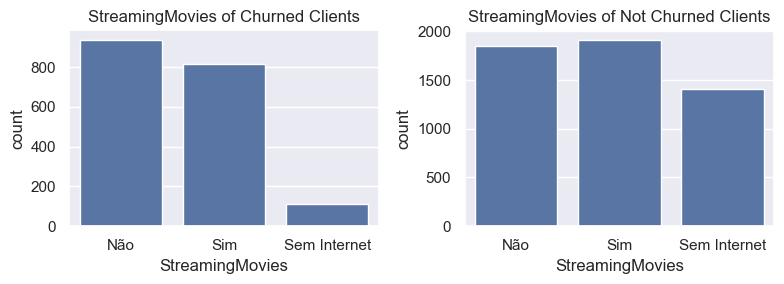

In [39]:
for i in l_internet_cols:
    plt.figure(figsize=(8,3))

    plt.subplot(1, 2, 1)
    sns.countplot(data=churned, x=i)
    plt.title(f'{i} of Churned Clients')
    plt.xticks(np.arange(3), ['Não', 'Sim', 'Sem Internet'])

    plt.subplot(1, 2, 2)

    sns.countplot(data=not_churned, x=i)
    plt.title(f'{i} of Not Churned Clients')
    plt.xticks(np.arange(3), ['Não', 'Sim', 'Sem Internet'])
    
    plt.tight_layout()
    plt.show()

Há uma grande diferença entre os clientes que possuem os serviços de Internet e os que não possuem, sendo que o impacto é negativo, há que se observar os serviçoes de internet forncedios.<br>
Dentre as colunas de serviço, as colunas que tem maior quantidade de Churn são as de Streaming de Filmes e TV.

### 4.5 Quantidade de Churn

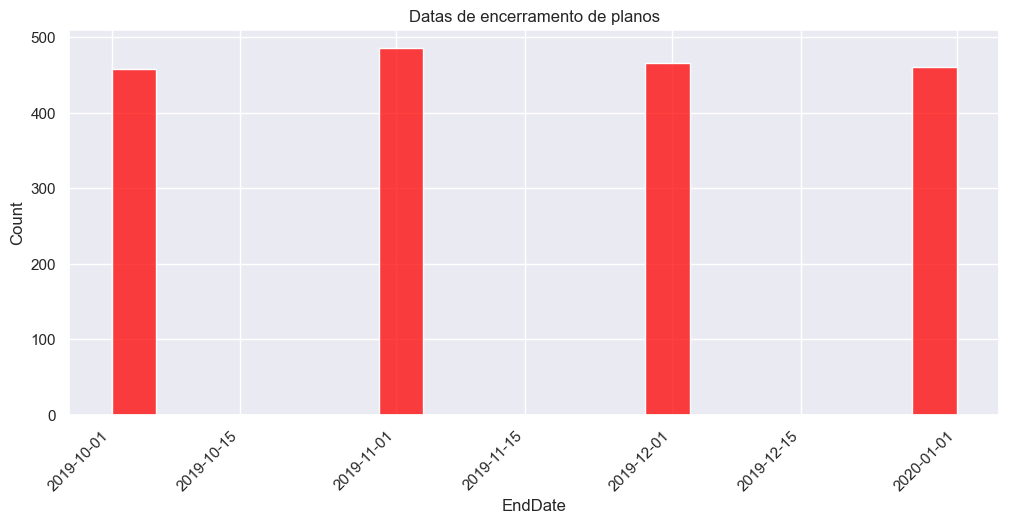

In [40]:
plt.figure(figsize=(12,5))

sns.histplot(data=df_final, x="EndDate", color='red')

plt.title('Datas de encerramento de planos')
plt.xticks(rotation=45, ha='right')
plt.show()

Os dados mostram que os clientes começaram a deixar a empresa a partir de Outubro, com uma quantidade constante de aproximadamente 500.

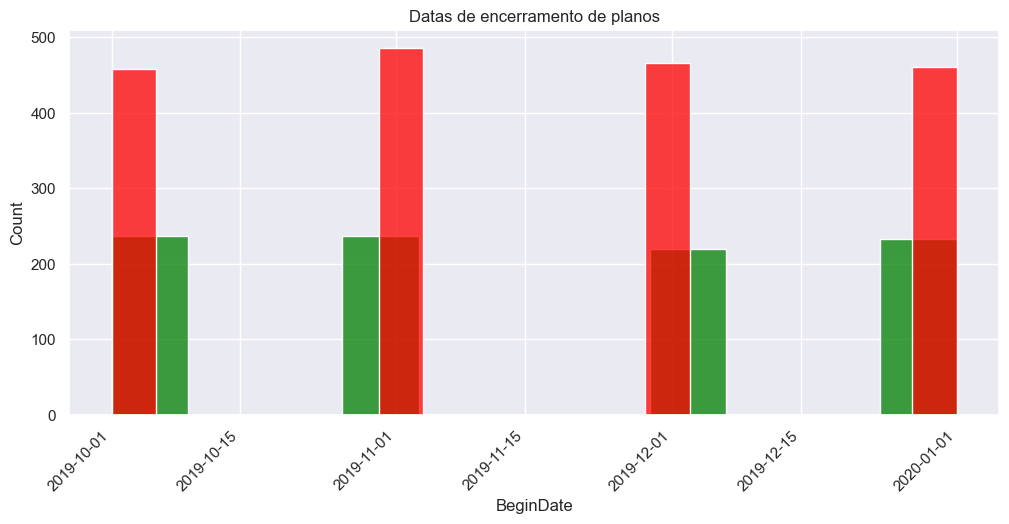

In [41]:
dft = df_final[(df_final['BeginDate'] > '2019-09-01') & (df_final['BeginDate'] < '2020-02-01')] 
plt.figure(figsize=(12,5))

sns.histplot(data=dft, x="BeginDate", color='green')
sns.histplot(data=df_final, x="EndDate", color='red')

plt.title('Datas de encerramento de planos')
plt.xticks(rotation=45, ha='right')
plt.show()

Comparando com a assinatura de novos planos, é possível perceber que o saldo está negativo e a empresa está perdendo clientes,

### 4.6 Informações sobre pagamento

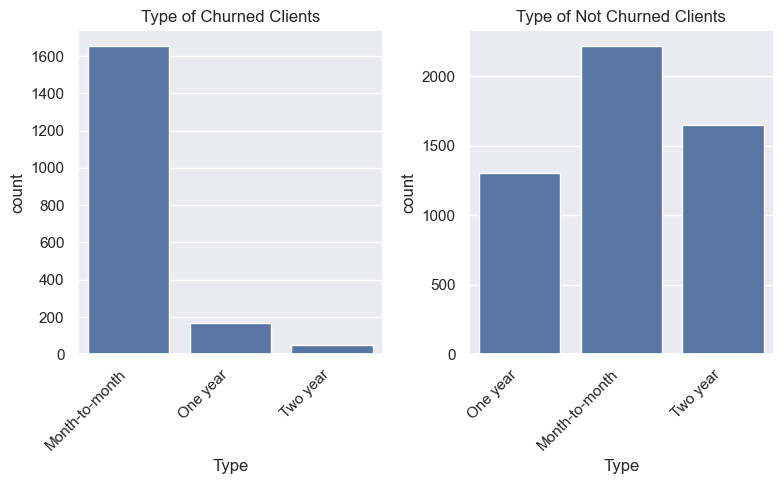

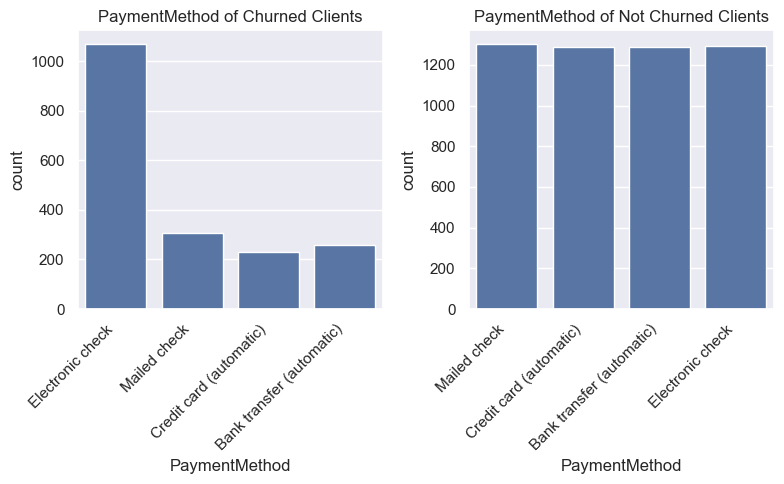

In [42]:
for i in ['Type', 'PaymentMethod']:
    plt.figure(figsize=(8,5))

    plt.subplot(1, 2, 1)
    sns.countplot(data=churned, x=i)
    plt.title(f'{i} of Churned Clients')
    #plt.xticks(np.arange(3), ['Não', 'Sim', 'Sem Internet'])
    plt.xticks(rotation=45, ha='right')

    plt.subplot(1, 2, 2)

    sns.countplot(data=not_churned, x=i)
    plt.title(f'{i} of Not Churned Clients')
    #plt.xticks(np.arange(3), ['Não', 'Sim', 'Sem Internet'])
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()


Os clientes que tem maior probabilidade de deixar a empresa são aqueles que têm assinatura mensal, mesmo que representem a grande maioria dos clientes, a proporção é muito maior que os outros tipos de assinatura quando comparado aos clientes que tem contrato com a empresa.<br>
O método de pagamento através de cheque eletrônico é o único que tem influência na decisão de romper o contrato com a empresa.


## 5. Preparar Dados para modelos

In [43]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   Tenure            7043 non-null   int64         
 10  InternetService   7043 non-null   float64       
 11  OnlineSecurity    7043 non-null   float64       
 12  OnlineBackup      7043 non-null   float64       
 13  DeviceProtection  7043 non-null   float64       
 14  TechSupport       7043 n

Primeiramente, as colunas 'customerID', 'BeginDate' e 'EndDate' serão excluídas porque não são características para treinamento do modelo.

In [44]:
# Colunas que não são características
ignore_columns = ['customerID', 'BeginDate', 'EndDate', 'gender']

In [45]:
# Dropando colunas que não serão utilizadas pelo Modelo
df_model = df_final.drop(ignore_columns, axis=1)

In [46]:
# One Hot Encodingo as colunas Type e Payment Method
categorical_features = ['Type', 'PaymentMethod']
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')
ohe_transform = ohe.fit_transform(df_model[categorical_features])
df_model = pd.concat([df_model, ohe_transform], axis=1).drop(columns=categorical_features)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   PaperlessBilling                         7043 non-null   int64  
 1   MonthlyCharges                           7043 non-null   float64
 2   TotalCharges                             7043 non-null   float64
 3   Churn                                    7043 non-null   int64  
 4   Tenure                                   7043 non-null   int64  
 5   InternetService                          7043 non-null   float64
 6   OnlineSecurity                           7043 non-null   float64
 7   OnlineBackup                             7043 non-null   float64
 8   DeviceProtection                         7043 non-null   float64
 9   TechSupport                              7043 non-null   float64
 10  StreamingTV                              7043 no

In [47]:
# Verificar correlação entre o alvo e as características
print(df_model.corr(numeric_only=True)['Churn'].sort_values(ascending=False))

Churn                                      1.000000
Type_Month-to-month                        0.405103
PaymentMethod_Electronic check             0.301919
MonthlyCharges                             0.193356
PaperlessBilling                           0.191825
SeniorCitizen                              0.150889
MultipleLines                              0.019423
InternetService                           -0.047291
PaymentMethod_Mailed check                -0.091683
PaymentMethod_Bank transfer (automatic)   -0.117937
PaymentMethod_Credit card (automatic)     -0.134302
Partner                                   -0.150448
Dependents                                -0.164221
Type_One year                             -0.177820
TotalCharges                              -0.198324
StreamingTV                               -0.205742
StreamingMovies                           -0.207256
DeviceProtection                          -0.281465
OnlineBackup                              -0.291449
Type_Two yea

As colunas com correlação entre -0.1 e 0.1 não fazem muita diferença para o nosso modelo, portanto serão descartadas

In [48]:
df_model = df_model.drop(['PaymentMethod_Mailed check', 'InternetService', 'MultipleLines'], axis=1)

In [49]:
df_model.head()

,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,SeniorCitizen,Partner,Dependents,Type_Month-to-month,Type_One year,Type_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check
0,1,65.6,593.30,0,9,0.0,1.0,0.0,1.0,1.0,0.0,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0
1,0,59.9,542.40,0,9,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,73.9,280.85,1,4,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0
3,1,98.0,1237.85,1,13,0.0,1.0,1.0,0.0,1.0,1.0,1,1,0,1.0,0.0,0.0,0.0,0.0,1.0
4,1,83.9,267.40,1,3,0.0,0.0,0.0,1.0,1.0,0.0,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0


In [50]:
# Colunas Numéricas
numeric_features = ['MonthlyCharges', 'TotalCharges', 'Tenure']

# Colunas Categóricas
cat_features = [col for col in df_model.columns if col not in numeric_features and col != 'Churn']

In [52]:
#Separando características e Alvo
X = df_model.drop(['Churn'], axis=1)
y = df_model['Churn']

In [53]:
# Separando os conjuntos de treino e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y , random_state=12345)


In [54]:
from imblearn.over_sampling import SMOTE

sm = SMOTE (random_state=12345)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [55]:
# Normalização das colunas numéricas

scaler = StandardScaler()

X_train_res[numeric_features] = scaler.fit_transform(X_train_res[numeric_features])

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])

In [56]:
# Dicionário para armazenar o score dos modelos para posterior comparação
models = {}

### 5.1 Funções para Treinamento e Avaliação do Modelo

In [57]:
# Método para Avaliar o Modelo com base no roc_auc_score
def eval_model(y_test, pred_proba, name):
    roc_auc = roc_auc_score(y_test, pred_proba)
    print(f'ROC_AUC Score: {roc_auc}')
    print('----------------')
    print('Gráfico ROC_AUC:')
    plt.figure(figsize=(10,3))
    
    fpr, tpr, _ = roc_curve(y_test,  pred_proba)
    auc = roc_auc_score(y_test, pred_proba)
    plt.plot(fpr,tpr,label=f"{name}, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    
    models[name] = [roc_auc]

In [58]:
# Treina o Modelo e Procura hiperparametros
def train_model(model, X_train, y_train, X_test, y_test, name, param_dist=None):
    if param_dist == None:
        model.fit(X_train, y_train)
    else:
        random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=50, cv=5, scoring='roc_auc', random_state=12345, n_jobs=-1)
        random_search.fit(X_train, y_train)
        model = random_search.best_estimator_
    
    
    pred_proba = model.predict_proba(X_test)[:, 1]

    eval_model(y_test, pred_proba, name)
    
    return model


## 6. Construção dos Modelos

### 6.1 Logistic Regression

ROC_AUC Score: 0.4967036089798239
----------------
Gráfico ROC_AUC:


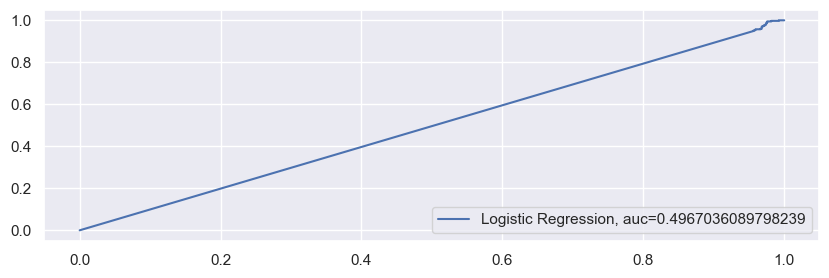

In [59]:
lr_model = train_model(LogisticRegression(), X_train, y_train, X_test, y_test, 'Logistic Regression')

ROC_AUC Score: 0.49670231729055253
----------------
Gráfico ROC_AUC:


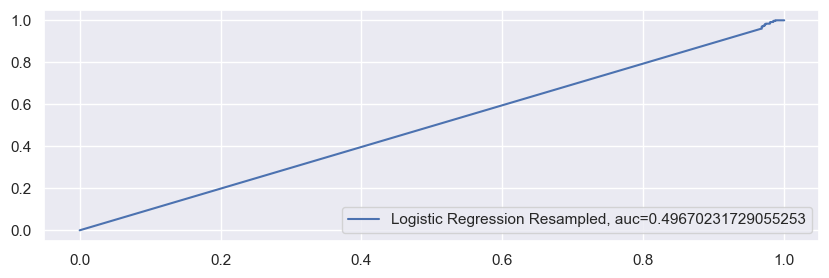

In [60]:
# Oversampled
lr_model_res = train_model(LogisticRegression(), X_train_res, y_train_res, X_test, y_test, 'Logistic Regression Resampled')

### 6.2 Floresta Aleatória

In [61]:
param_dist_rf = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

ROC_AUC Score: 0.8306479113384484
----------------
Gráfico ROC_AUC:


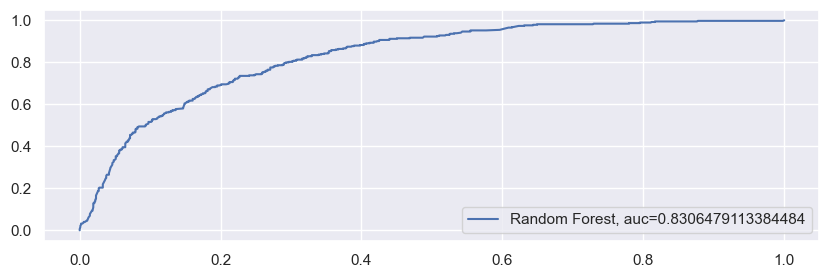

In [62]:
rf_model = train_model(RandomForestClassifier(), X_train, y_train, X_test, y_test, 'Random Forest', param_dist_rf)

ROC_AUC Score: 0.799339946782402
----------------
Gráfico ROC_AUC:


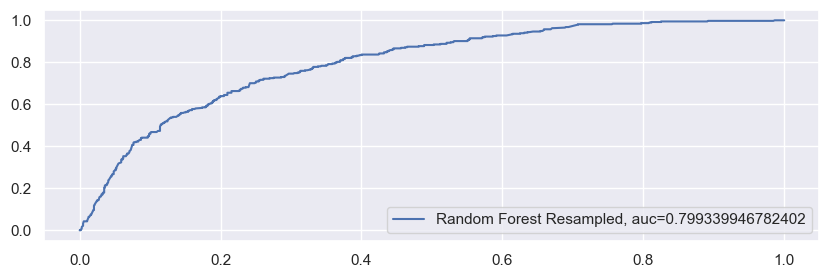

In [63]:
rf_model_res = train_model(RandomForestClassifier(), X_train_res, y_train_res, X_test, y_test, 'Random Forest Resampled', param_dist_rf)

### 6.3 CatBoost

In [64]:
param_dist_catboost = {
    'iterations': randint(100, 1000),
    'depth': randint(4, 10),
    'learning_rate': uniform(0.01, 0.3),
    'l2_leaf_reg': uniform(1, 10),
    'border_count': randint(32, 255)
}

ROC_AUC Score: 0.7863713864992637
----------------
Gráfico ROC_AUC:


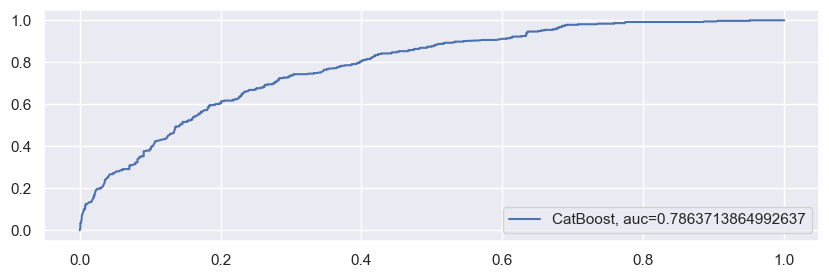

In [65]:
catb_model = train_model(CatBoostClassifier(verbose=0), X_train, y_train, X_test, y_test, 'CatBoost', param_dist_catboost)

ROC_AUC Score: 0.7489382314190498
----------------
Gráfico ROC_AUC:


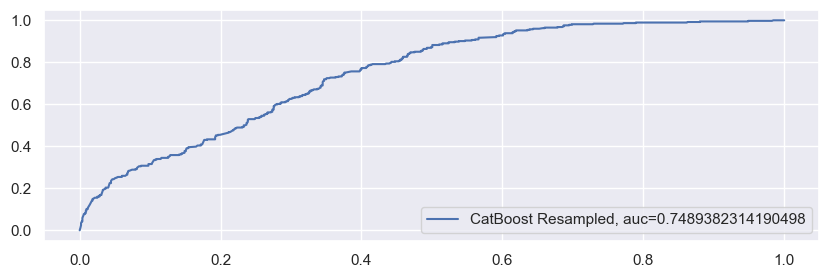

In [66]:
catb_model_res = train_model(CatBoostClassifier(verbose=0), X_train_res, y_train_res, X_test, y_test, 'CatBoost Resampled', param_dist_catboost)

### 6.4 LightGBM

In [67]:
param_dist_lgb = {
    'n_estimators': randint(100, 1000),
    'num_leaves': randint(20, 150),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
ROC_AUC Score: 0.8246790152160997
----------------
Gráfico ROC_AUC:


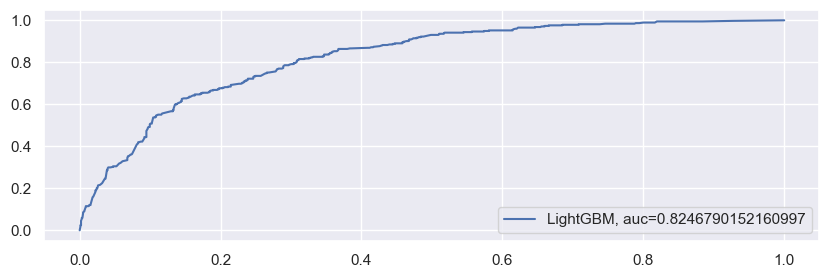

In [68]:
lgb_model = train_model(lgb.LGBMClassifier(), X_train, y_train, X_test, y_test, 'LightGBM', param_dist_lgb)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3440
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

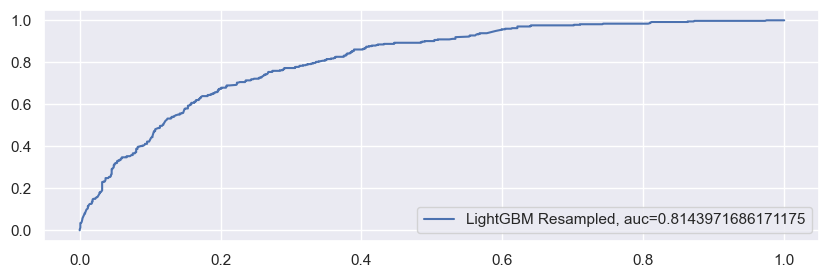

In [69]:
lgb_model_res = train_model(lgb.LGBMClassifier(), X_train_res, y_train_res, X_test, y_test, 'LightGBM Resampled', param_dist_lgb)

### 6.5 XGBoost

In [70]:
param_dist_xgb = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(1, 20),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

ROC_AUC Score: 0.8458330104110154
----------------
Gráfico ROC_AUC:


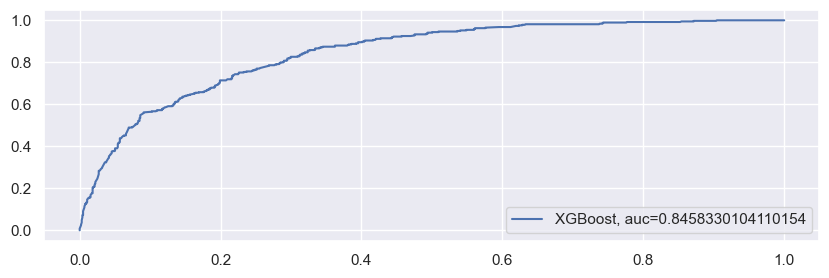

In [71]:
xgb_model = train_model(xgb.XGBClassifier(), X_train, y_train, X_test, y_test, 'XGBoost', param_dist_xgb)

ROC_AUC Score: 0.7938864346792736
----------------
Gráfico ROC_AUC:


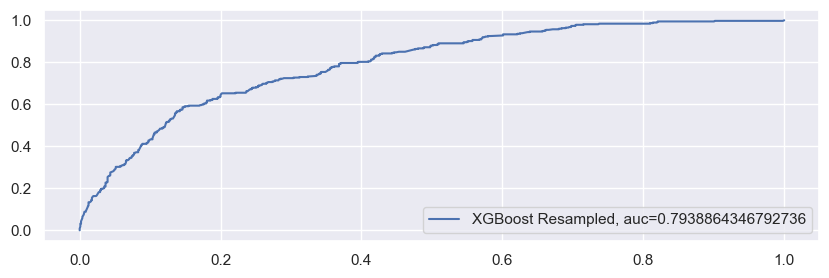

In [72]:
xgb_model_res = train_model(xgb.XGBClassifier(), X_train_res, y_train_res, X_test, y_test, 'XGBoost Resampled', param_dist_xgb)

## 7. Avaliação Modelos

In [73]:
classifiers_df = pd.DataFrame(models.values(), index=models.keys(), columns=['ROC_AUC'])
classifiers_df

,ROC_AUC
Logistic Regression,0.496704
Logistic Regression Resampled,0.496702
Random Forest,0.830648
Random Forest Resampled,0.799340
CatBoost,0.786371
CatBoost Resampled,0.748938
LightGBM,0.824679
LightGBM Resampled,0.814397
XGBoost,0.845833
XGBoost Resampled,0.793886


O modelo com melhor ROC_AUC foi o XGBoost.

### 7.1 Características XGBoost

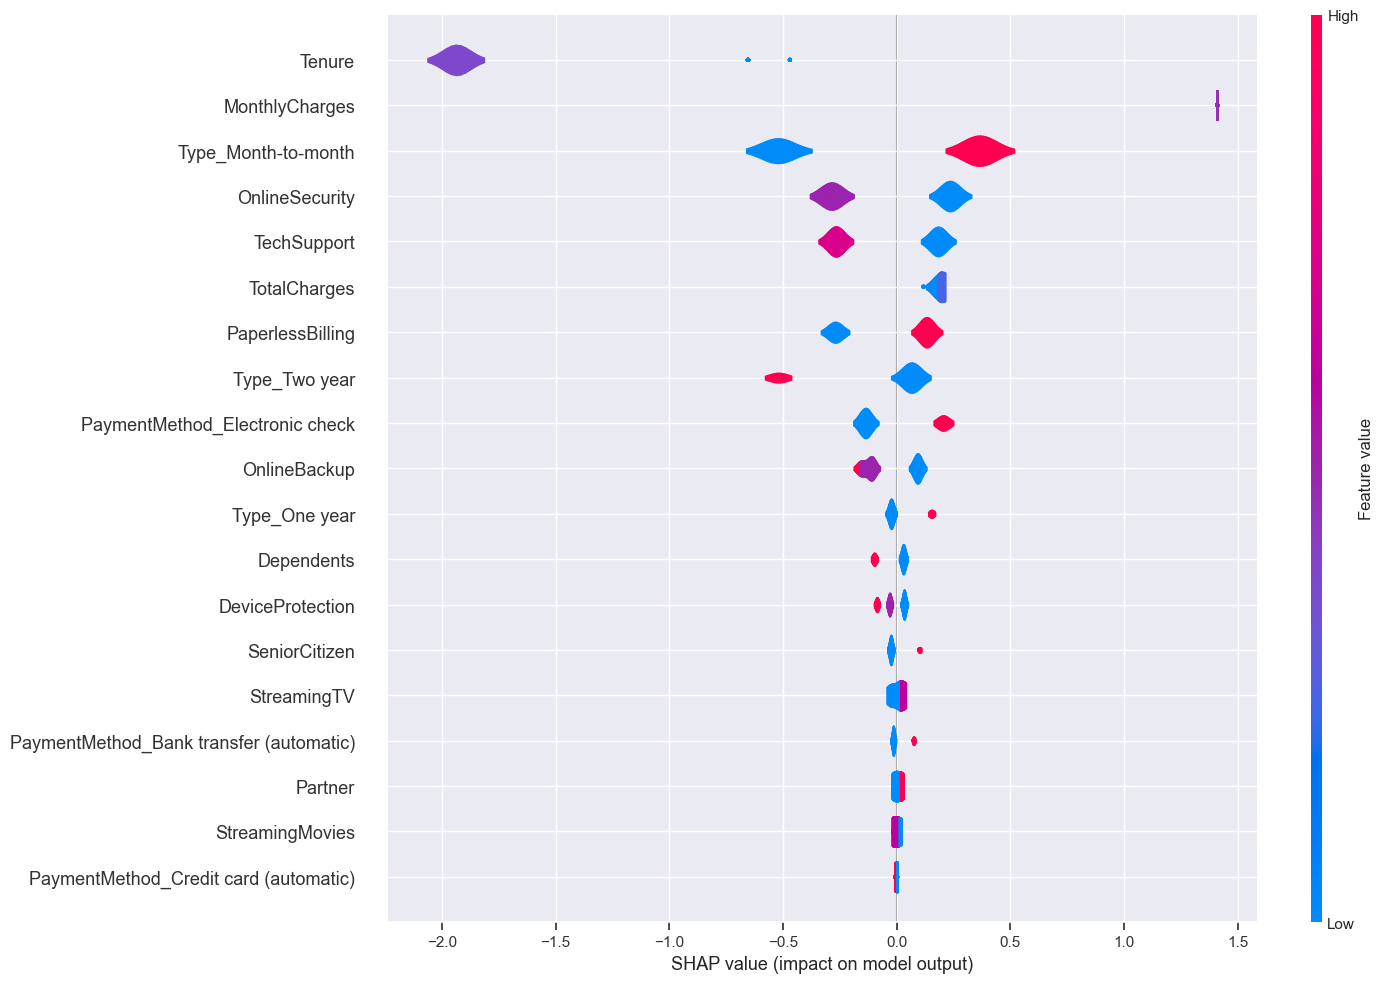

In [74]:
import shap

explainer = shap.Explainer(xgb_model)

shap_values = explainer(X)
shap.summary_plot(shap_values, X, plot_type="violin", plot_size=(15,10))

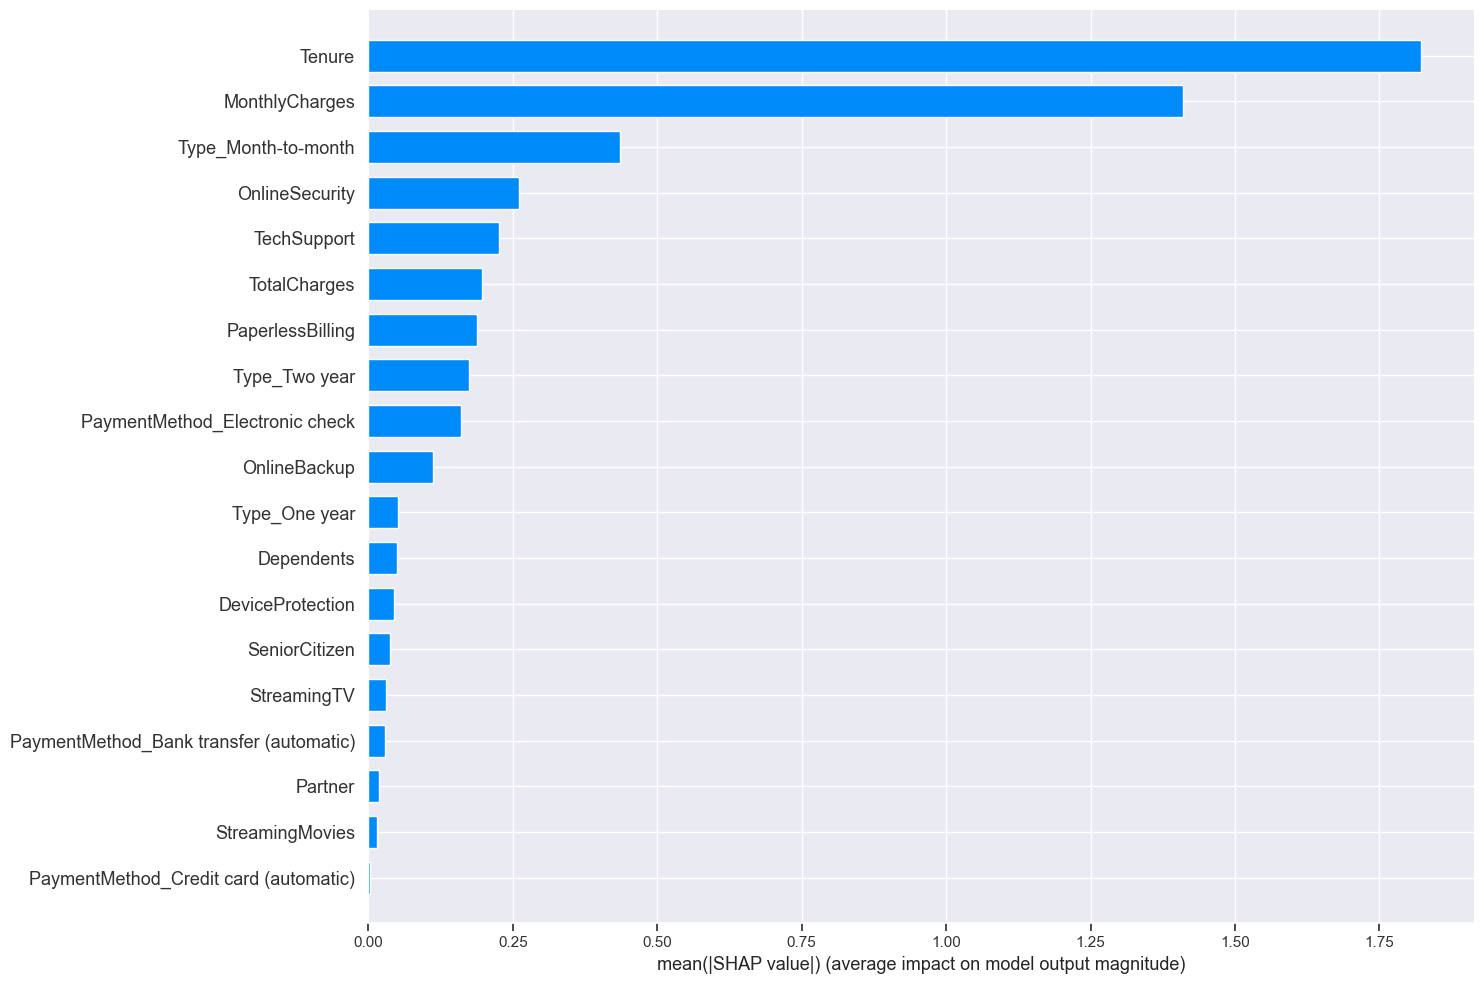

In [75]:
shap.summary_plot(shap_values, X, plot_type="bar", plot_size=(15,10))

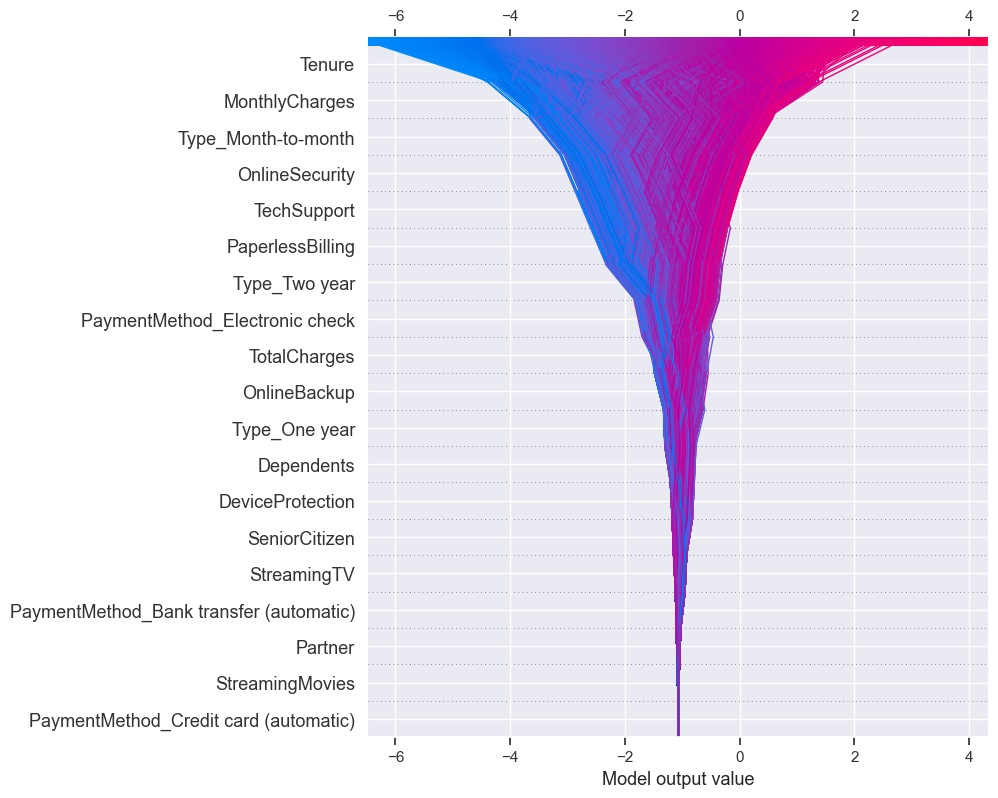

In [76]:
shap.decision_plot(base_value= explainer.expected_value, shap_values=explainer.shap_values(X_train), features=X.columns, ignore_warnings=True)

## 8. Relatório Final

**Perfil alvo de Cliente:** Clientes idosos, que vivem sozinhos. São os clientes com possuem maior taxa de Churn.<br>
Não há quantidade alta de clientes, mas são o perfil de cliente que tem maior probabilidade de encerrar o contrato.<br>
**Serviços:** Verificar se há algum problema nos serviços de StreamingTV e Streaming de filmes, pois eles têm alta porcentagem junto aos clientes que deixaram a empresa em relação aos outros serviços.<br>
Como fica claro na avaliação do modelo, oferecer suporte técnico e segurança online tem impacto, oferecer esses serviços aos clientes que não possuem é uma boa estratégia para manter os clientes.<br>
**Meio de Pagamento:** Clientes com pagamento através de cheque eletrônico também tem maior tendência a sair do que clientes que utilizam outros meios, verificar se há algum problema, ou se está ligado ao perfil de cliente que já sairia da empresa.<br>
**Tipo de subscrição:** Clientes que tem pagamento mensal são mais sucetiveis a deixar a empresa. <br>
**Tempo de contrato:** A maioria das saídas ocorrem no primeiro ano de contrato, especialmente antes dos 10 meses. Estratégias para fidelizar o cliente, como oferecer descontos, pacotes interessantes especialmente para os serviços Streaming podem alcançar maior retenção.

Para a modelagem, o EDA foi essencial para identificar características com forte influência no objetivo da análise e características que não tinham impacto, além de ampliar o entendimento dos clientes alvos.<br>

Para tranformar os dados, a normalização e a técnica OHE ajudaram para que os modelos fossem alimentados de forma adequada e eficiente.<br>

E por fim o uso de RandomizedSearchCV nos ajudou a encontrar bons hiperparametros para alcançarmos um ROC_AUC de quase 0.85.